# **Motor de recomendación de películas**
*Gonzalo Izaguirre (diciembre 2020)*
___

El objetivo de este notebook es crear un motor de recomendación a partir del contenido del fichero `movie_metadata.csv`.Este dataset contiene alrededor de 5000 películas y series, y su descripción ha sido recogida de la base de datos de IMDB. Basicamente, el sistema funcionará de la siguiente forma: después de que el usuario haya introducido el nombre de una película que le haya gustado, el sistema seleccionará del conjunto total 5 películas que agradarán al usuario al ser similares. Existen tres tipos de filtros colaborativos:
- Sistemas **popularity-based**: los más simples de implementar, aunque los más impersonales
- Sistemas **content-based**: La recomendación se basa en la descripción del producto
- Sistemas **collaborative filtering**: datos de diferentes usuarios dan recomendaciones basadas en similaridades entre usuarios.

En este caso, dado que el conjunto de datos solo describe el contenido de las películas, no puede aplicarse el filtrado colaborativo. Se creará un motor que usará tanto el contenido como la popularidad de las entradas.
___
El notebook se organiza de la siguiente manera:

**1. Exploración**
- 1.1 Keywords
- 1.2 Factor de completitud: Valores Faltantes
- 1.3 Películas por año
- 1.4 Géneros

**2. Limpieza**
- 2.1 Entradas duplicadas
- 2.2 Limpieza de keywords
    * 2.2.1 Agrupamiento por lexema
    * 2.2.2 Agrupamiento por sinónimos
- 2.3 Correlaciones
- 2.4 Valores faltantes
    * 2.4.1 Años faltantes
    * 2.4.2 Extrayendo keywords del título
    * 2.4.3 Completado de datos mediante regresión
    
**3. Recommendation Engine**
- 3.1 Funcionamiento básico del motor 
    * 3.1.1 Similaridad
    * 3.1.2 Popularidad
- 3.2 Definicion de las funciones del motor de recomendación
- 3.3 Realizando recomendaciones interesantes
- 3.4 Ejemplo de recomendación

**4. Conclusión: posibles mejoras y puntos a concretar**



___
## 1. Exploración

 Se cargan todos los paquetes y el conjunto de datos. Se da información sobre los tipos de las columnas y los datos faltantes.

In [1]:
import json
import pandas as pd

/Users/gizaguirre/.virtualenvs/recommendation/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:

def carga_peliculas(ruta):
    """Función utilizada para cargar el dataset de las películas. Se transforma a fecha el campo de fecha de salida
    y se cargan como listas los campos que están guardados como json.
    
    Args:
        ruta (str): Ruta hasta el archivo de tmdb_5000_peliculas.csv
    
    Returns:
        pd.DataFrame: Dataframe de pandas con la información del csv
    """
    df = pd.read_csv(ruta)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for columna in json_columns:
        df[columna] = df[columna].apply(json.loads)
    return df


def carga_creditos(ruta):
    """Función utilizada para cargar el dataset de los créditos. Se cargan como listas los campos que están guardado
    
    Args:
        ruta (str): Ruta hasta el archivo de tmdb_5000_creditos.csv

    Returns:
        pd.DataFrame:
    """
    df = pd.read_csv(ruta)
    json_columns = ['cast', 'crew']
    for columna in json_columns:
        df[columna] = df[columna].apply(json.loads)
    return df

In [3]:
EQUIVALENCIAS_TMDB_IMDB = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',  # it's possible that spoken_languages would be a better match
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users',
                                         }

COLUMNAS_IMDB_REMAP = {'imdb_score': 'vote_average'}

In [4]:
%config IPCompleter.greedy=True

In [5]:
def get_elemento(contenedor, valores_indice):
    """Función para acceder de forma segura a valores. En caso de que no se encuentre uno de ellos, se devuelve NaN
    en vez de lanzar un error.
    
    Args:
        contenedor (list): Lista/ contenedor de la que quieren extraerse los valores
        valores_indice (list): Lista de índices a extraer del contenedor
    
    Returns:
        any: Valores extraidos
    """
    result = contenedor
    try:
        for idc in valores_indice:
            result = result[idc]
        return result
    except IndexError or KeyError:
        return pd.np.nan


def get_director(datos_equipo):
    """Devuelve el director dado un json con toda la composición del equipo de la película.
    
    Args:
        datos_equipo (json): JSON con el equipo que ha realizado la película
    
    Returns:
        str: Director de la película
    """
    directores = [x['name'] for x in datos_equipo if x['job'] == 'Director']
    return get_elemento(directores, [0])


def aplana_nombres(keywords):
    """Obtiene una lista con las keywords separadas por un pipe | extrayéndolas del json.
    
    Args:
        keywords (json): keywords de la película
    
    Returns:
        str: keywords de la película juntas
    """
    return '|'.join([x['name'] for x in keywords])


def combina_colecciones(peliculas, creditos):
    """Aplica una serie de funciones para añadir información al dataset de películas a partir del
    conjunto de datos de créditos
    
    Args:
        peliculas (pd.DataFrame): DataFrame obtenido de leer el archivo de películas
        creditos (pd.DataFrame): DataFrame obtenido de leet el archivo de créditos
    
    Returns:
        pd.DataFrame: DataFrame con la información conjunta
    """
    tmdb_peliculas = peliculas.copy()
    tmdb_peliculas.rename(columns=EQUIVALENCIAS_TMDB_IMDB, inplace=True)
    tmdb_peliculas['title_year'] = pd.to_datetime(tmdb_peliculas['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_peliculas['country'] = tmdb_peliculas['production_countries'].apply(lambda x: get_elemento(x, [0, 'name']))
    tmdb_peliculas['language'] = tmdb_peliculas['spoken_languages'].apply(lambda x: get_elemento(x, [0, 'name']))
    tmdb_peliculas['director_name'] = creditos['crew'].apply(get_director)
    tmdb_peliculas['actor_1_name'] = creditos['cast'].apply(lambda x: get_elemento(x, [1, 'name']))
    tmdb_peliculas['actor_2_name'] = creditos['cast'].apply(lambda x: get_elemento(x, [2, 'name']))
    tmdb_peliculas['actor_3_name'] = creditos['cast'].apply(lambda x: get_elemento(x, [3, 'name']))
    tmdb_peliculas['genres'] = tmdb_peliculas['genres'].apply(aplana_nombres)
    tmdb_peliculas['plot_keywords'] = tmdb_peliculas['plot_keywords'].apply(aplana_nombres)
    return tmdb_peliculas

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')

#Definimos la función a utilizar para obtener el lexema de las palabras.
PS = nltk.stem.PorterStemmer()
#__________________
# load the dataset
#df_inicial = pd.read_csv("../input/movie_metadata.csv")
creditos = carga_creditos("../RecommendationEngine/datos/tmdb_5000_credits.csv")
peliculas = carga_peliculas("../RecommendationEngine/datos/tmdb_5000_movies.csv")
df_inicial = combina_colecciones(peliculas, creditos)
print('Shape:',df_inicial.shape)
#__________________________________________
# Información sobre los tipos de variable y el factor de completitud
tab_info=pd.DataFrame(df_inicial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_inicial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_inicial.isnull().sum()/df_inicial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

/Users/gizaguirre/.virtualenvs/recommendation/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Shape: (4803, 26)


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,production_countries,release_date,gross,duration,spoken_languages,status,tagline,movie_title,vote_average,num_voted_users,title_year,country,director_name,actor_1_name,actor_2_name,actor_3_name
column type,int64,object,object,int64,object,object,object,object,float64,object,object,object,int64,float64,object,object,object,object,float64,int64,float64,object,object,object,object,object
null values,0,0,3091,0,0,86,0,3,0,0,0,1,0,2,0,0,844,0,0,0,1,174,30,53,63,93
null values (%),0.0,0.0,64.355611,0.0,0.0,1.790548,0.0,0.062461,0.0,0.0,0.0,0.02082,0.0,0.041641,0.0,0.0,17.572351,0.0,0.0,0.0,0.02082,3.622736,0.62461,1.103477,1.31168,1.93629


In [7]:
print(tab_info.to_latex())

\begin{tabular}{lllllllllllllllllllllllllll}
\toprule
{} & budget &  genres &   homepage &     id & plot\_keywords &  language & original\_title &  overview & popularity & production\_companies & production\_countries & release\_date &  gross &  duration & spoken\_languages &  status &    tagline & movie\_title & vote\_average & num\_voted\_users & title\_year &   country & director\_name & actor\_1\_name & actor\_2\_name & actor\_3\_name \\
\midrule
column type     &  int64 &  object &     object &  int64 &        object &    object &         object &    object &    float64 &               object &               object &       object &  int64 &   float64 &           object &  object &     object &      object &      float64 &           int64 &    float64 &    object &        object &       object &       object &       object \\
null values     &      0 &       0 &       3091 &      0 &             0 &        86 &              0 &         3 &          0 &                    0 &       

___
### 1.1 Keywords

Para desarrollar el sistema de recomendación, se hará un uso extensivo de las palabras clave que describen las películas. De hecho, una asunción básica en el proyecto es que las películas descritas por keywords similares deberían tener contenido similar. Por tanto, se realizará un analisis de cómo están definidas las keywords en un primer paso. En primer lugar, veamos las keywords que hay en el conjunto de datos.

In [8]:
set_keywords = set()
for lista_keywords in df_inicial['plot_keywords'].str.split('|').values:
    if isinstance(lista_keywords, float): continue  # Evitar las películas en las que no hay keywords
    set_keywords = set_keywords.union(lista_keywords)

y después definir una funciónq ue cuenta el numero de veces que aparece cada uno:

In [9]:
def cuenta_palabra(df, ref_col, lista):
    """Toma una columna de un dataframe y un set de valores y devuelve un diccionario y una lista
    con el numero de apariciones de cada elemento de la lista en la columna del dataframe

    Args:
        df (pd.DataFrame]): DataFrame del que extraer la información
        ref_col (str): Columna de la que extraer los valores diferentes
        lista (list): Lista con los diferentes valores de los que extraer sus apariciones
    Returns:
        list: Número de apariciones
        dict: Número de apariciones

    """
    keyword_count = dict()
    for s in lista: keyword_count[s] = 0
    for lista_keywords in df[ref_col].str.split('|'):
        if type(lista_keywords) == float and pd.isnull(lista_keywords): continue
        #for s in lista:
        for s in [s for s in lista_keywords if s in lista]:
            if pd.notnull(s): keyword_count[s] += 1
    
    # convertir el diccionario en una lista para ordenar las keywords por frecuencia
    veces_keyword = []
    for k,v in keyword_count.items():
        veces_keyword.append([k,v])
    veces_keyword.sort(key = lambda x:x[1], reverse = True)
    return veces_keyword, keyword_count

Esta función se usará de nuevo en otras secciones del notebook, cuando se explore el contenido de la variable `generos` y, obviamente, cuando limpiemos las keywords. Finalmente, llamando a esta funcion tenemos acceso a la lista de kweywords que están ordenadas en orden decreciente por número de apariciones.

In [10]:
# Diferentes keywords y número de apariciones
veces_keyword, _ = cuenta_palabra(df_inicial, 'plot_keywords', set_keywords)
veces_keyword[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [11]:
# Se retiran las keywords que son vacías
veces_keyword = [x for x in veces_keyword if x[0]]
veces_keyword[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 189]]

En este momento, la lista de palabras ha sido creada y sabemos el número de veces que aparece cada una en el set de datos. De hecho, esta lista puede usarse para tener cierta intuicion del contenido de las películas más populares. Una forma interesante de dar esta información hace uso del paquete *wordcloud*. En este tipo de representación, todas las palabras se sitúan en la figura con tamaños que dependen de su frecuencia. En vez de una nube de palabras, se pueden usar histogramas. Esto permite tener una figura en la que las keywords están ordenadas por frecuencia de aparición y nos da la posibilidad de conocer la frecuencia exacta de cada palabra, tarea que no puede realizarse viendo únicamente la nube de palabras.

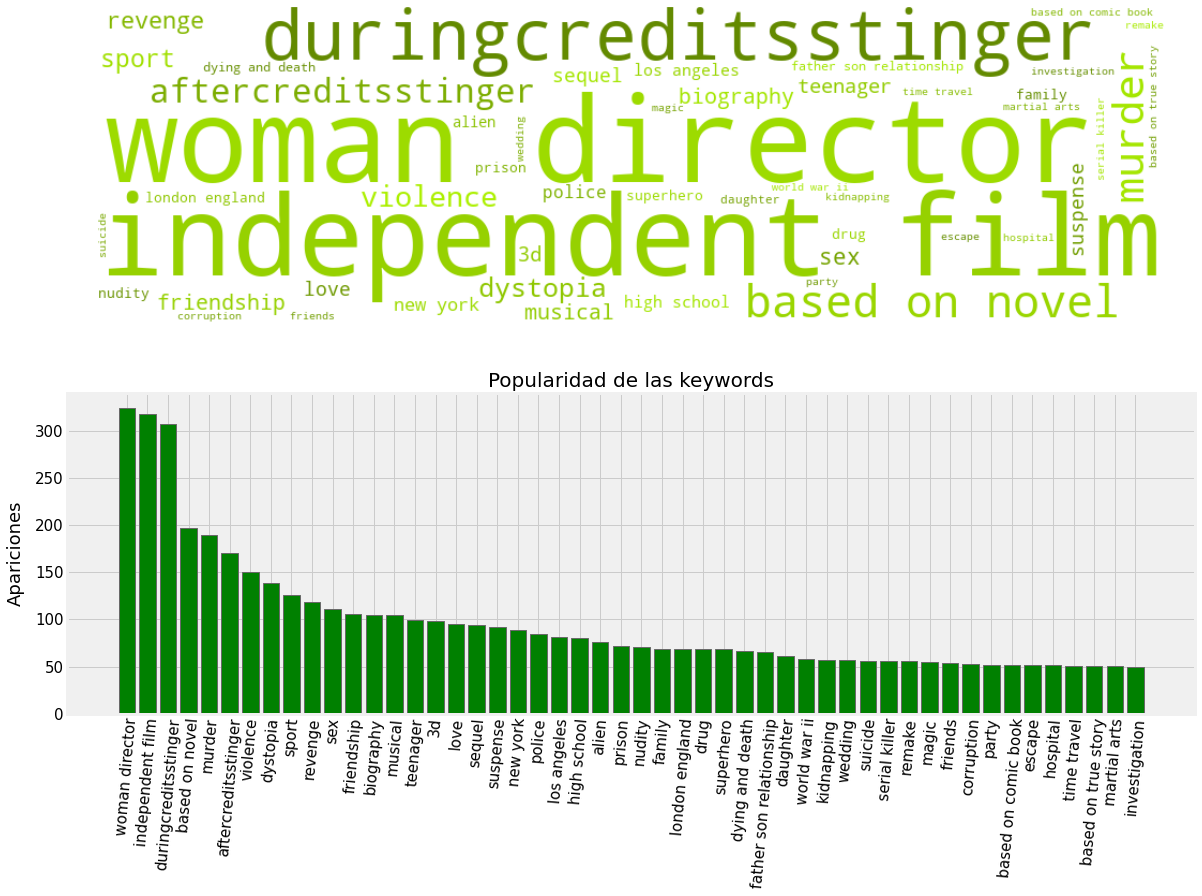

In [12]:
def color_aleatorio(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#_____________________________________________
# Nube de palabras
fig = plt.figure(1, figsize=(18,13))
ej1 = fig.add_subplot(2,1,1)
#_______________________________________________________
# Diccionario usado para generar la imagen
palabras = dict()
veces_trunc = veces_keyword[0:50]
for s in veces_trunc:
    palabras[s[0]] = s[1]
tone = 55.0 # define the color of the words
#________________________________________________________
nube = WordCloud(width=1000,height=300, background_color='white', 
                      max_words=1628,relative_scaling=1,
                      color_func = color_aleatorio,
                      normalize_plurals=False)
nube.generate_from_frequencies(palabras)
ej1.imshow(nube, interpolation="bilinear")
ej1.axis('off')
#_____________________________________________
# Histograma
ej2 = fig.add_subplot(2,1,2)
eje_y = [i[1] for i in veces_trunc]
eje_x = [k for k,i in enumerate(veces_trunc)]
etiqueta_x = [i[0] for i in veces_trunc]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(eje_x, etiqueta_x)
plt.ylabel("Apariciones", fontsize = 18, labelpad = 10)
ej2.bar(eje_x, eje_y, align = 'center', color='g')
#_______________________
plt.title("Popularidad de las keywords",fontsize = 20)
plt.show()

___
### 1.2 Factor de completitud: Valores Faltantes

El conjunto de datos consiste en 5043 películas o series que están descritas mediante 28 variables. Como en todo análisis, habrá que trater con los valores faltantes y, como un primer paso, se calcula la cantidad de datos faltantes en cada variable:

In [13]:
df_faltantes = df_inicial.isnull().sum(axis=0).reset_index()
df_faltantes.columns = ['column_name', 'missing_count']
df_faltantes['filling_factor'] = (df_inicial.shape[0] 
                                - df_faltantes['missing_count']) / df_inicial.shape[0] * 100
df_faltantes.sort_values('filling_factor').reset_index(drop = True)


,column_name,missing_count,filling_factor
0,homepage,3091,35.644389
1,tagline,844,82.427649
2,country,174,96.377264
3,actor_3_name,93,98.063710
4,language,86,98.209452
5,actor_2_name,63,98.688320
6,actor_1_name,53,98.896523
7,director_name,30,99.375390
8,overview,3,99.937539
9,duration,2,99.958359


Podemos ver que la integridad de los datos es bastante buena, ya que únicamente 2 de las 28 variables tienen un factor de competitud menor del 93%.

___
### 1.3 Películas por año

La variable **title_year** indica cuándo se lanzó una película. Para tener una visión global de la forma en la que las películas se distribuyen según esta variable, las agrupamos por décadas:

In [14]:
#Obtenemos la década de cada película

df_inicial['decade'] = df_inicial['title_year'].apply(lambda x:((x-1900)//10)*10)
def get_estadisticas(gr):
    """Devuelve las estadísticas de un DataFrame agrupado
    
    Arguments:
        gr -- DataFrame agrupado
    
    Returns:
        dict -- Diccionario que contiene las estadísticas principales de cada grupo
    """
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}#______________________________________________________________
# Creación de un DataFrame con información estadística de cada década
test = df_inicial['title_year'].groupby(df_inicial['decade']).apply(get_estadisticas).unstack()

y representamos los resultados en un diagrama de sectores

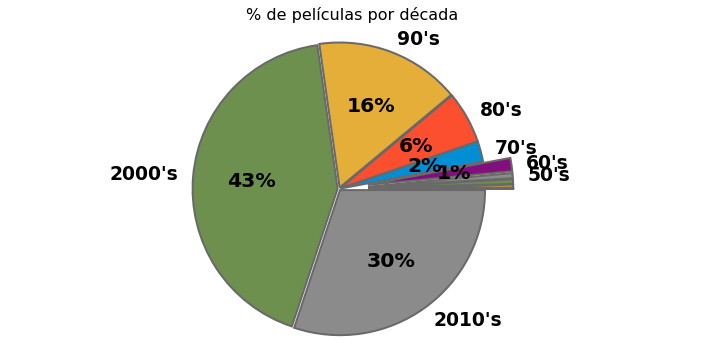

In [15]:
sns.set_context("poster", font_scale=0.85)


def etiqueta(s):
    """
    Get de label from the decade. If XX Century-> last 2 digits.
    Else -> complete year
    """
    val = (1900 + s, s)[s < 100]
    cadena = '' if s < 50 else "{}'s".format(int(val))
    return cadena

plt.rc('font', weight='bold')
f, ej = plt.subplots(figsize=(11, 6))
etiquetas = [etiqueta(s) for s in  test.index]
tamanos  = test['count'].values
explode = [0.2 if tamanos[i] < 100 else 0.01 for i in range(11)]
ej.pie(tamanos, explode = explode, labels=etiquetas,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ej.axis('equal')
ej.set_title('% de películas por década', fontsize=16);
df_inicial.drop('decade', axis=1, inplace = True)

___
### 1.4 Géneros

La variable **genres** será importante en la creación del sistema de recomendación, dado que describe el contenido de la película. Para ver exactamente qué generos son los mas populares, se usa la misma aproximación que con las keywords.

In [16]:
etiquetas_generos = set()
for s in df_inicial['genres'].str.split('|').values:
    etiquetas_generos = etiquetas_generos.union(set(s))

y cada genero aparece las siguientes veces:

In [17]:
veces_keyword, dum = cuenta_palabra(df_inicial, 'genres', etiquetas_generos)
veces_keyword[:5]

[['Drama', 2297],
 ['Comedy', 1722],
 ['Thriller', 1274],
 ['Action', 1154],
 ['Romance', 894]]

In [18]:
veces_keyword = [x for x in veces_keyword if x[0]]

Se muestra el resultado como una nube de palabras

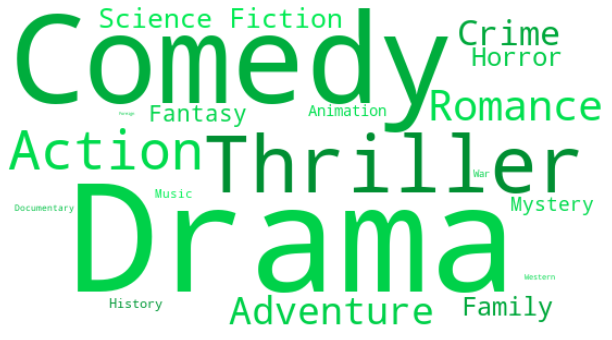

In [19]:
palabras = dict()
veces_trunc = veces_keyword[0:50]
for s in veces_trunc:
    palabras[s[0]] = s[1]
tone = 100 # define the color of the words
_, _ = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = color_aleatorio,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(palabras)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

___
## 2. Limpieza
___

### 2.1 Entradas duplicadas

Hasta ahora, sólo mirabamos unas pocas variables e intentábamos representar su contenido para tener una idea de su significado. Por tanto, es ahora cuando empieza realmente la tarea de limpieza.

El primer paso consiste en buscar entradas duplicadas. Como un primer paso, se comprueba si si las hay.

In [20]:
entradas_duplicadas = df_inicial[df_inicial.id.duplicated()]
entradas_duplicadas.shape

(0, 26)

In [21]:
df_temp = df_inicial

Ahora examinamos las filas con entradas duplicadas teniendo en cuenta únicamente las variables **movie\_title** y **title\_year**, and **director\_name**:

In [22]:
lista_var_de_duplicados = ['movie_title', 'title_year', 'director_name']

Creamos una lista con las entradas con títulos idénticos:

In [23]:
lista_duplicados = df_temp['movie_title'].map(df_temp['movie_title'].value_counts() > 1)
print("Número de entradas duplicadas: {}".format(
    len(df_temp[lista_duplicados][lista_var_de_duplicados])))

Número de entradas duplicadas: 6


y a continuación examinamos algunos casos. Dado que no hay demasiados valores, es posible hacerlo a simple vista:

In [24]:
df_temp[lista_duplicados][lista_var_de_duplicados].sort_values('movie_title')

,movie_title,title_year,director_name
1359,Batman,1989.0,Tim Burton
4267,Batman,1966.0,Leslie H. Martinson
3647,Out of the Blue,1980.0,Dennis Hopper
3693,Out of the Blue,2006.0,Robert Sarkies
972,The Host,2013.0,Andrew Niccol
2877,The Host,2006.0,Bong Joon-ho


Puede verse que estas películas son únicamente remakes.


In [25]:
df_limpio_duplicados = df_temp

___
### 2.2 Limpieza de keywords

Las keywords tendrán un papel fundamental en el funcionamiento del sistema. De hecho, las recomendaciones se basaran en la similaridad entre películas. Para medir esas similaridades, se mirarán las películas descritas por las mismas keywords. Por tanto, el contenido de la variable **plot_keywords** debe ser analizado, ya que será muy utilizado.

___
#### 2.2.1 Agrupamiento por lexema

Cogemos las keywords que aparecen en **plot_keywords**. Esta lista se limpia usando NLTK. Finalmente, veremos la ocurrencia de cada keyword.

In [26]:
def inventario_keywords(dataframe, columna = 'plot_keywords'):
    """Devuelve un diccionario con las palabras que derivan de cada lexema
    a partir de un DataFrame y la columna de la que se quiere extraer
    
    Args:
        dataframe (pd.DataFrame): DataFrame del que obtener la información.
        columna (str, optional): Nombre de la columna. Defaults to 'plot_keywords'.
    
    Returns:
        list: Keywords finales que aparecen
        dict: Relación lexema <-> palabras
        dict: Palabra más corta derivada del lexema
    """
    PS = nltk.stem.PorterStemmer()
    keywords_raices  = dict()  # recoger las palabras de cada lexema
    keywords_selecciona = dict()  # asociacion: lexema <-> keyword
    category_keys = []
    icuenta = 0
    for s in dataframe[columna]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower()
            raiz = PS.stem(t)
            # Para cada lexema, un set con las palabras que lo usan
            if raiz in keywords_raices:                
                keywords_raices[raiz].add(t)
            else:
                keywords_raices[raiz] = {t}
    
    for s in keywords_raices.keys():
        if len(keywords_raices[s]) > 1:  
            longtud_min = 1000
            for k in keywords_raices[s]:
                if len(k) < longtud_min:
                    clave = k ; longtud_min = len(k)            
            category_keys.append(clave)
            keywords_selecciona[s] = clave
        else:
            category_keys.append(list(keywords_raices[s])[0])
            keywords_selecciona[s] = list(keywords_raices[s])[0]
                   
    print("Número de keywords en la variable: '{}': {}".format(columna,len(category_keys)))
    return category_keys, keywords_raices, keywords_selecciona

In [27]:
keywords, keywords_raices, keywords_selecciona = inventario_keywords(df_limpio_duplicados,
                                                               columna = 'plot_keywords')

Número de keywords en la variable: 'plot_keywords': 9474


In [28]:
# Muestra de keywords que aparecen en formas similares

icuenta = 0
for s in keywords_raices.keys():
    if len(keywords_raices[s]) > 1: 
        icuenta += 1
        if icuenta < 15:
            print(icuenta, keywords_raices[s], len(keywords_raices[s]))

1 {'alienation', 'alien'} 2
2 {'spying', 'spy'} 2
3 {'vigilantism', 'vigilante'} 2
4 {'terror', 'terrorism'} 2
5 {'flooding', 'flood'} 2
6 {'spider', 'spiders'} 2
7 {'horse', 'horses'} 2
8 {'musical', 'music'} 2
9 {'anime', 'animation', 'animal'} 3
10 {'compassion', 'compass'} 2
11 {'training', 'train'} 2
12 {'sailing', 'sail'} 2
13 {'time traveler', 'time travel'} 2
14 {'orcs', 'orc'} 2


In [29]:
# Reemplazo de keywords por su forma principal
def df_reemplazo_keywords(df, dicc_reemplazo, raiz = False, columna = 'plot_keywords'):
    """Reemplaza las palabras clave de una película por las formas básicas de las mismas.

    Args:
        df (pd.DataFrame): DataFrame que contiene la información de las películas
        dicc_reemplazo (dict): Diccionario con los cambios
        raiz (bool, optional): Controla si se obtienen las raices de las palabras de las
        keywords. Defaults to False.
        columna (str, optional): Columna en la que realizar la transformación. Defaults to 'plot_keywords'.

    Returns:
        pd.DataFrame: DataFrame con las sustituciones realizadas
    """
    PS = nltk.stem.PorterStemmer()
    df_nuevo = df.copy(deep = True)
    for indice, fila in df_nuevo.iterrows():
        cadena = fila[columna]
        if pd.isnull(cadena): continue
        nueva_lista = []
        for s in cadena.split('|'): 
            clave = PS.stem(s) if raiz else s
            if clave in dicc_reemplazo.keys():
                nueva_lista.append(dicc_reemplazo[clave])
            else:
                nueva_lista.append(s)       
        df_nuevo.at[indice, columna] = '|'.join(nueva_lista)
    return df_nuevo

In [30]:
# Reemplazo de keywords por su forma principal

df_limpio_keywords = df_reemplazo_keywords(df_limpio_duplicados, keywords_selecciona,
                                               raiz = True)

In [31]:
# Conteo de la repetición de cada Keyword

veces_keyword, keywords_cuenta = cuenta_palabra(df_limpio_keywords,'plot_keywords',keywords)
veces_keyword[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [32]:
len(keywords_cuenta)

9474

___
#### 2.2.2 Grupos de *sinónimos*

Limpiamos la lista de keywords en dos pasos. En un primer paso, se suprimer las keywords que aparecen menos de 5 veces y se reemplazan por un sinónimo de mayor frecuencia. En un segundo paso, se suprimen las keywords que aparecen en menos de 3 películas.

In [33]:
# Obtener los sinónimos de la palabra 'keyword'

def toma_sinonimos(keyword):
    """Se obtienen los sinónimos sustantivos de una palabra
    
    Args:
        keyword (str): Palabra de la que obtener los sinónimos
    
    Returns:
        list: Lista con los sinónimos
    """

    lexema = set()
    for ss in wordnet.synsets(keyword):
        for p in ss.lemma_names():
            #  Obtenemos los sinónimos que son sustantivos
            indice = ss.name().find('.')+1
            if ss.name()[indice] == 'n': lexema.add(p.lower().replace('_',' '))
    return lexema   

In [34]:
# Ejemplo de una lista de sinónimos dados por NLTK

keyword = 'alien'
lexema = toma_sinonimos(keyword)
for s in lexema:
    print(' "{:<30}" in keywords list -> {} {}'.format(s, s in keywords,
                                                keywords_cuenta[s] if s in keywords else 0 ))

 "outlander                     " in keywords list -> False 0
 "alien                         " in keywords list -> True 80
 "extraterrestrial              " in keywords list -> True 4
 "extraterrestrial being        " in keywords list -> False 0
 "stranger                      " in keywords list -> True 7
 "foreigner                     " in keywords list -> False 0
 "unknown                       " in keywords list -> False 0
 "noncitizen                    " in keywords list -> False 0


In [35]:
# Comprobar si 'word' es una clave con más ocurrecncias que el umbral   

def prueba_keyword(palabra, keyword_apariciones, umbral):
    """Devuelve si una palabra aparece un número mayor de veces que el umbral señalado

    Args:
        palabra (str): Palabra a buscar
        keyword_apariciones (dict): Diccionario con las apariciones de cada keyword
        umbral (int): Umbral

    Returns:
        bool: True si aparece un número mayor de veces
    """
    return (False , True)[keyword_apariciones.get(palabra, 0) >= umbral] 

In [36]:
veces_keyword.sort(key = lambda x:x[1], reverse = False)
keyword_cuenta = dict()
for s in veces_keyword:
    keyword_cuenta[s[0]] = s[1]
#__________________________________________________________________________
# Creación de un diccionario para reemplazar keywords por sinónimos de mayor frecuencia
palabra_reemplazo = dict()
icuenta = 0
for _, [palabra, num_apariciones] in enumerate(veces_keyword):
    if num_apariciones > 5:
        continue  # Sólo las keywords que aparecen menos de 5 veces
    lexema = toma_sinonimos(palabra)
    if len(lexema) == 0:
        continue     #Caso de plurales
    lista_palabras = [(s, keyword_cuenta[s]) for s in lexema 
                  if prueba_keyword(s, keyword_cuenta, keyword_cuenta[palabra])]
    lista_palabras.sort(key = lambda x:(x[1],x[0]), reverse = True)    
    if len(lista_palabras) <= 1:
        continue       # NO se reemplaza
    if palabra == lista_palabras[0][0]:
        continue    # Reemplazo por sí mismo
    icuenta += 1
    if  icuenta < 8:
        print('{:<12} -> {:<12} (inic: {})'.format(palabra, lista_palabras[0][0], lista_palabras))
    palabra_reemplazo[palabra] = lista_palabras[0][0]

print(90*'_'+'\n'+'El reemplazo afecta a un {}% de las keywords.'
      .format(round(len(palabra_reemplazo)/len(keywords)*100,2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
El reemplazo afecta a un 5.97% de las keywords.


In [37]:
# 2 reemplazos sucesivos

print('Palabras que aparecen tanto en clave como en valor:'.upper()+'\n'+45*'-')
icuenta = 0
for s in palabra_reemplazo.values():
    if s in palabra_reemplazo.keys():
        icuenta += 1
        if icuenta < 10: print('{:<20} -> {:<20}'.format(s, palabra_reemplazo[s]))

for clave, valor in palabra_reemplazo.items():
    if valor in palabra_reemplazo.keys():
        palabra_reemplazo[clave] = palabra_reemplazo[valor]                    

PALABRAS QUE APARECEN TANTO EN CLAVE COMO EN VALOR:
---------------------------------------------
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


In [38]:
# Se reemplazan variaciones de una keyword por su keyword principal

df_sinonimos_keywords = \
            df_reemplazo_keywords(df_limpio_keywords, palabra_reemplazo, raiz = False)   
keywords, keywords_raices, keywords_selecciona = \
            inventario_keywords(df_sinonimos_keywords, columna = 'plot_keywords')

Número de keywords en la variable: 'plot_keywords': 8909


In [39]:
# Nuevo conteo de la ocurrencia de cada keyword

new_veces_keyword, keywords_cuenta = cuenta_palabra(df_sinonimos_keywords,
                                                    'plot_keywords',keywords)
new_veces_keyword[:5]

[['', 412],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

In [40]:
# Borrrado de keywords con baja frecuencia

def reemplazo_keywords_baja_frecuencia(df, veces_keyword):
    """Modifica las entradas del dataframe, quitando las keywords que aparecen menos 
    de 3 veces.

    Args:
        df (pd.DataFrame): DataFrame de películas
        veces_keyword ([type]): Diccionario que contiene la ocurrencia de cada keyword

    Returns:
        pd.Dataframe: DataFrame con las nuevas keywords
    """
    df_nuevo = df.copy(deep = True)
    cuenta_clave = dict()
    for s in veces_keyword: 
        cuenta_clave[s[0]] = s[1]
    for indice, fila in df_nuevo.iterrows():
        cadena = fila['plot_keywords']
        if pd.isnull(cadena): continue
        nueva_lista = []
        for s in cadena.split('|'):
            if cuenta_clave.get(s, 4) > 3: nueva_lista.append(s)
        df_nuevo.at[indice, 'plot_keywords'] = '|'.join(nueva_lista)
    return df_nuevo  

In [43]:
# Creation of a dataframe where keywords of low frequencies are suppressed

df_apariciones_keywords = \
    reemplazo_keywords_baja_frecuencia(df_sinonimos_keywords, new_veces_keyword)
keywords, keywords_raices, keywords_selecciona = \
    inventario_keywords(df_apariciones_keywords, columna = 'plot_keywords')

Número de keywords en la variable: 'plot_keywords': 2121


In [44]:
# Nuevo conteo de ocurrencia

new_veces_keyword, keywords_cuenta = cuenta_palabra(df_apariciones_keywords,
                                                    'plot_keywords',keywords)
new_veces_keyword[:5]

[['', 508],
 ['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197]]

findfont: Font family ['sams-serif'] not found. Falling back to DejaVu Sans.


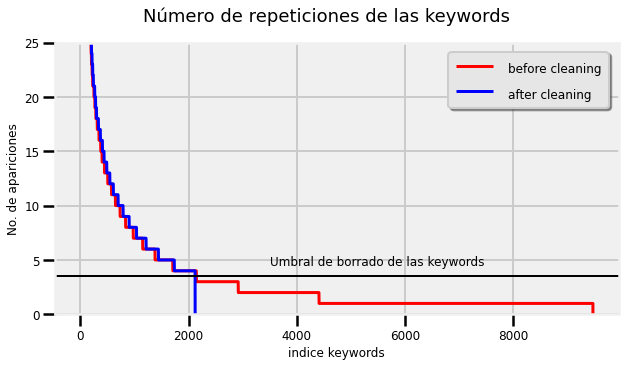

In [45]:
# Gráfico de ocurrencia de las keyword

fuente = {'family' : 'sans-serif', 'weight' : 'normal', 'size'   : 12}
mpl.rc('font', **fuente)

veces_keyword.sort(key = lambda x:x[1], reverse = True)

eje_y = [i[1] for i in veces_keyword]
eje_x = [k for k,i in enumerate(veces_keyword)]

eje_y_nuevo = [i[1] for i in new_veces_keyword]
eje_x_nuevo = [k for k,i in enumerate(new_veces_keyword)]

f, ej = plt.subplots(figsize=(9, 5))
ej.plot(eje_x, eje_y, 'r-', label='pre limpieza')
ej.plot(eje_x_nuevo, eje_y_nuevo, 'b-', label='post limpieza')

ej.tick_params(axis='both', which='major', labelsize=fuente['size'])


# Now add the legend with some customizations.
leyenda = ej.legend(loc='upper right', shadow=True)
marco = leyenda.get_frame()
marco.set_facecolor('0.90')
for etiqueta in leyenda.get_texts():
    etiqueta.set_fontsize('medium')
            
plt.ylim((0,25))
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("indice keywords", family='sans-serif', fontsize = fuente['size'])
plt.ylabel("No. de apariciones", family='sams-serif', fontsize = fuente['size'])
plt.suptitle("Número de repeticiones de las keywords", fontsize = 18, family='sans-serif')
plt.text(3500, 4.5, 'Umbral de borrado de las keywords', fontsize = fuente['size'])
plt.show()

___
### 2.3 Correlaciones

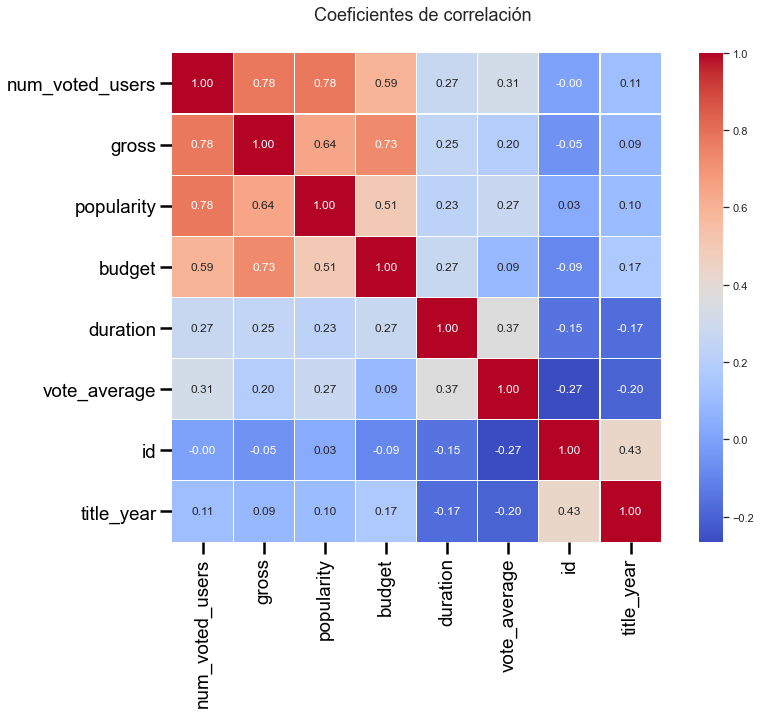

In [46]:
f, ej = plt.subplots(figsize=(12, 9))
#_____________________________
# Cálculo de correlaciones
corrmat = df_apariciones_keywords.dropna(how='any').corr()
#________________________________________
k = 17 # number of variables for heatmap
cols = corrmat.nlargest(k, 'num_voted_users')['num_voted_users'].index
cm = np.corrcoef(df_apariciones_keywords[cols].dropna(how='any').values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'coolwarm',
                 yticklabels=cols.values, xticklabels=cols.values)
f.text(0.5, 0.93, "Coeficientes de correlación", ha='center', fontsize = 18, family='sans-serif')
plt.show()

In [47]:
COLUMNAS_PERDIDAS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews'
                ]

In [48]:
nuevo_orden_columnas = ['movie_title', 'title_year', 'genres', 'plot_keywords', 
                 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
                 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                 'actor_3_facebook_likes', 'movie_facebook_likes', 'num_critic_for_reviews', 
                 'num_user_for_reviews', 'num_voted_users', 'language', 'country',
                 'imdb_score', 'movie_imdb_link', 'color', 'duration', 'gross', ]
nuevo_orden_columnas = [col for col in nuevo_orden_columnas if col not in COLUMNAS_PERDIDAS]
print(nuevo_orden_columnas)
nuevo_orden_columnas = [COLUMNAS_IMDB_REMAP[col] if col in COLUMNAS_IMDB_REMAP else col
                 for col in nuevo_orden_columnas]
print(nuevo_orden_columnas)
nuevo_orden_columnas = [EQUIVALENCIAS_TMDB_IMDB[col] if col in EQUIVALENCIAS_TMDB_IMDB else col
                 for col in nuevo_orden_columnas]
print(nuevo_orden_columnas)
df_var_limpio = df_apariciones_keywords[nuevo_orden_columnas]

['movie_title', 'title_year', 'genres', 'plot_keywords', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'num_voted_users', 'language', 'country', 'imdb_score', 'duration', 'gross']
['movie_title', 'title_year', 'genres', 'plot_keywords', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'num_voted_users', 'language', 'country', 'vote_average', 'duration', 'gross']
['movie_title', 'title_year', 'genres', 'plot_keywords', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'num_voted_users', 'language', 'country', 'vote_average', 'duration', 'gross']


In [49]:
set2 = set(list(df_var_limpio.columns))

In [50]:
set1 = set(list(df_apariciones_keywords.columns))
set1.difference(list(df_var_limpio.columns))

{'budget',
 'homepage',
 'id',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'spoken_languages',
 'status',
 'tagline'}

___
###  2.4 Valores faltantes

Examinamos el número de valores faltantes en cada variable y escogemos una metodología para completar el dataset.

In [51]:
df_faltantes = df_var_limpio.isnull().sum(axis=0).reset_index()
df_faltantes.columns = ['column_name', 'missing_count']
df_faltantes['filling_factor'] = (df_var_limpio.shape[0] 
                                - df_faltantes['missing_count']) / df_var_limpio.shape[0] * 100
df_faltantes = df_faltantes.sort_values('filling_factor').reset_index(drop = True)
df_faltantes

,column_name,missing_count,filling_factor
0,country,174,96.377264
1,actor_3_name,93,98.063710
2,language,86,98.209452
3,actor_2_name,63,98.688320
4,actor_1_name,53,98.896523
5,director_name,30,99.375390
6,duration,2,99.958359
7,title_year,1,99.979180
8,movie_title,0,100.000000
9,genres,0,100.000000


Ahora representamos el contenido de esta tabla:

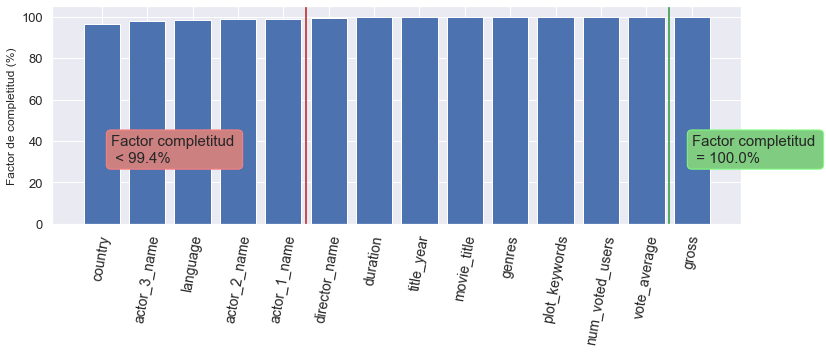

In [52]:
eje_y = df_faltantes['filling_factor'] 
etiqueta_x = df_faltantes['column_name']
eje_x = df_faltantes.index

fig = plt.figure(figsize=(11, 4))
plt.xticks(rotation=80, fontsize = 12)
plt.yticks(fontsize = 13)

N_umbral = 5
plt.axvline(x=N_umbral-0.5, linewidth=2, color = 'r')
plt.text(N_umbral-4.8, 30, 'Factor completitud \n < {}%'.format(round(eje_y[N_umbral],1)),
         fontsize = 15, family = 'sans-serif', bbox=dict(boxstyle="round",
                   ec=(1.0, 0.5, 0.5),
                   fc=(0.8, 0.5, 0.5)))
N_umbral = 13
plt.axvline(x=N_umbral-0.5, linewidth=2, color = 'g')
plt.text(N_umbral, 30, 'Factor completitud \n = {}%'.format(round(eje_y[N_umbral],1)),
         fontsize = 15, family = 'sans-serif', bbox=dict(boxstyle="round",
                   ec=(0.5, 1., 0.5),
                   fc=(0.5, 0.8, 0.5)))

plt.xticks(eje_x, etiqueta_x,family='sans-serif', fontsize = 14 )
plt.ylabel('Factor de completitud (%)', family='sans-serif', fontsize = 12)
plt.bar(eje_x, eje_y);

___
#### 2.4.1 Completando los años faltantes

Para inferir el año de la película, se usan los actores y el director. Para cada uno de ellos, determinamos el año medio de actividad, utilizando el dataset que tenemos. A continuación, se promedian los valores para determinar el año de la película.

In [53]:
def rellena_ano(df):
    """Completa la columna faltante del año teniendo en cuenta la media
    de los periodos de actividad de los actores y el director.
    """
    col = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']
    ano_habitual = [0 for _ in range(4)]
    var = [0 for _ in range(4)]
    # Año medio de actividad para los actores y el director
    for i in range(len(col)):
        ano_habitual[i] = df.groupby(col[i])['title_year'].mean()
    # Diccionario que recoja esta información
    ano_actor = dict()
    for i in range(4):
        for s in ano_habitual[i].index:
            if s in ano_actor.keys():
                if pd.notnull(ano_habitual[i][s]) and pd.notnull(ano_actor[s]):
                    ano_actor[s] = (ano_actor[s] + ano_habitual[i][s])/2
                elif pd.isnull(ano_actor[s]):
                    ano_actor[s] = ano_habitual[i][s]
            else:
                ano_actor[s] = ano_habitual[i][s]
        
    # Identificación de los años faltantes
    missing_year_info = df[df['title_year'].isnull()]
    # Completado de los valores faltantes
    icuenta_reemplazos = 0
    for indice, fila in missing_year_info.iterrows():
        valor = [ np.NaN for _ in range(4)]
        icuenta = 0 ; suma_ano = 0
        for i in range(4):            
            var[i] = df.loc[indice][col[i]]
            if pd.notnull(var[i]): valor[i] = ano_actor[var[i]]
            if pd.notnull(valor[i]): icuenta += 1 ; suma_ano += ano_actor[var[i]]
        if icuenta != 0: 
            suma_ano = suma_ano / icuenta 

        if int(suma_ano) > 0:
            icuenta_reemplazos += 1
            df.at[indice, 'title_year'] = int(suma_ano)
            if icuenta_reemplazos < 10: 
                print("{:<45} -> {:<20}".format(df.loc[indice]['movie_title'],int(suma_ano)))
    return 

In [54]:
df_rellenado = df_var_limpio.copy(deep=True)
rellena_ano(df_rellenado)

#### La comparación de algunas predicciones con valores reales presentan un grado de similaridad relativamente bueno
- Bewitched: **1951** -> en TV  entre 1964 y 1972 
- The A-team: **1977** -> en TV entre 1982 y 1987
- Sleepy Hollow: **2012** -> en TV entre 2013 y 2017

___
#### 2.4.2 Extracción de keywords del título

Como se ha dicho anteriormente, las keywords jugarán un papel fundamental en el funcionamiento del motor de recomendación. Por tanto, se tratará de rellenar los valores faltantes de la variable **plot_keywords** utilizando keywords del título. Para ello, se crea la lista de sinónimos de todas las palabras contenidas en el título y se comprueba si alguna de ellas se encuentra ya en la lista de keywords. En ese caso, se añade esa keyword a la película.

In [55]:
icuenta = 0
for indice, fila in df_rellenado[df_rellenado['plot_keywords'].isnull()].iterrows():
    icuenta += 1
    lista_palabras = fila['movie_title'].strip().split()
    nueva_keyword = []
    for s in lista_palabras:
        lexema = toma_sinonimos(s)
        for t in list(lexema):
            if t in keywords: 
                nueva_keyword.append(t)                
    if nueva_keyword and icuenta < 15: 
        print('{:<50} -> {:<30}'.format(fila['movie_title'], str(nueva_keyword)))
    if nueva_keyword:
        df_rellenado.at[indice, 'plot_keywords'] = '|'.join(nueva_keyword)

#### 2.4.3 Completando mediante regresiones

En la sección 2.4 se vio la correlación entre variabels y se encontro que algunas de ellas tenían una cierta correlación, con un coeficiente de Pearson $>0.5$:

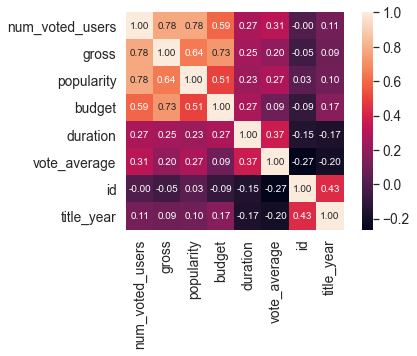

In [56]:
cols = corrmat.nlargest(9, 'num_voted_users')['num_voted_users'].index
mc = np.corrcoef(df_apariciones_keywords[cols].dropna(how='any').values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(mc, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Se usará este hallazgo para completar los valores faltantes de las variables **gross** y **num_voted_users**. Para ello, se realizarán regresiones en parejas de variables correlacionadas:

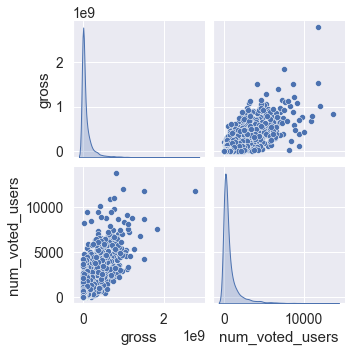

In [57]:
sns.set(font_scale=1.25)
#cols = ['gross', 'num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews']
cols = ['gross', 'num_voted_users']
sns.pairplot(df_rellenado.dropna(how='any')[cols],diag_kind='kde', size = 2.5)
plt.show();

En primer lugar, definimos una función que imputa los vbalores faltantes mediante un ajuste lineal de los datos:

In [58]:
def imputacion_regresion(df, col_a_predecir, ref_col):
    """Completa los valores de la variable col_a_predecir haciendo una regresión
    lineal en la que la variable predictora es ref_col.

    Args:
        df (pd.DataFrame): DataFrame de películas
        col_a_predecir (str): Variable a predecir
        ref_col (str): Variable con la que predecir

    Returns:
        pd.DataFrame: DataFrame de películas completado
    """
    regr = linear_model.LinearRegression()
    test = df[[col_a_predecir,ref_col]].dropna(how='any', axis = 0)
    X = np.array(test[ref_col])
    Y = np.array(test[col_a_predecir])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr.fit(X, Y)

    test = df[df[col_a_predecir].isnull() & df[ref_col].notnull()]
    for indice, fila in test.iterrows():
        valor = float(regr.predict(fila[ref_col]))
        df.at[indice, col_a_predecir] =  valor
    return df

Esta función toma el dataframe como entrada y los nombres de dos columnas. Se realiza un ajuste lineal entre estas dos columnas y se usa para rellenar los datos faltantes de la primera columna dada:

In [59]:
df_rellenado = imputacion_regresion(df_rellenado, 'gross', 'num_voted_users')

Por último, puede verse a cantidad de información faltante aun en el dataframe:

In [60]:
df = df_rellenado.copy(deep = True)
df_faltantes = df.isnull().sum(axis=0).reset_index()
df_faltantes.columns = ['column_name', 'missing_count']
df_faltantes['filling_factor'] = (df.shape[0] 
                                - df_faltantes['missing_count']) / df.shape[0] * 100
df_faltantes = df_faltantes.sort_values('filling_factor').reset_index(drop = True)
df_faltantes

,column_name,missing_count,filling_factor
0,country,174,96.377264
1,actor_3_name,93,98.063710
2,language,86,98.209452
3,actor_2_name,63,98.688320
4,actor_1_name,53,98.896523
5,director_name,30,99.375390
6,duration,2,99.958359
7,title_year,1,99.979180
8,movie_title,0,100.000000
9,genres,0,100.000000


y puede verse que en el peor de los casos el la completitud está alrededor del 96%.

In [61]:
df = df_rellenado.copy(deep=True)
df.reset_index(inplace = True, drop = True)

___
## 3. MOTOR DE RECOMENDACIÓN

___
### 3.1 Funcionamiento básico del motor
El orden para construir el motor de recomendación tendrá dos pasos básicos:
1. Elegir $N$ películas con un contenido similar a la entrada dada por el usuario
2. Seleccionar las 5 películas mas populares de entre esas $N$ películas

#### 3.1.1 Similaridad

Cuando se construye el motor, el primer paso consiste en definir un criterio que pueda aportar información sobre cómo de parecidas son dos películas. En primer lugar, tenemos en cuenta la descripción de la película seleccionada por el usuario. De ahi tomamos el director, los nombres de los actores y algunas keywords. A partir de estos datos, creamos una matriz en la que cada fila se corresponde con una película de la base de datos y en la que las columnas corresponden con lo dicho anteriormente junto con los *k* generos que se describieron en la sección 1.4:

\begin{table}[]
\centering
\begin{tabular}{|l|l|l|l|l|l|l|l|l|l|l|}
\hline
\textbf{\begin{tabular}[c]{@{}l@{}}movie\\ title\end{tabular}} &
  \textbf{director} &
  \textbf{actor 1} &
  \textbf{a2} &
  \textbf{a3} &
  \textbf{keyword 1} &
  \textbf{k2} &
  \textbf{genre1} &
  \textbf{g2} &
  \textbf{...} &
  \textbf{gk} \\ \hline
Film1  & $a_{11}$ & $a_{12}$ &  &  & ...      &  &  &  & ... & $a_{1q}$ \\ \hline
...    &          &          &  &  & ...      &  &  &  & ... &          \\ \hline
Film i & $a_{i1}$ & $a_{i2}$ &  &  & $a_{ij}$ &  &  &  & ... & $a_{iq}$ \\ \hline
...    &          &          &  &  & ...      &  &  &  & ... &          \\ \hline
Film p & $a_{p1}$ & $a_{p2}$ &  &  & ...      &  &  &  & ... & $a_{pq}$ \\ \hline
\end{tabular}
\caption{Matriz generada para el cálculo de la similaridad entre dos películas}
\label{tab:similarity}
\end{table}

En esta matriz, el elemento $a_{ij}$ toma el valor 0 o 1 dependiendo de la correspondencia entre la significancia entre la columna $j$ y el contenido de la película $i$. Por ejemplo, si "keyword1" está en la película $i$, tendremos $a_{ij} = 1$ y $0$ en otro caso. Una vez esta matriz se ha definido, determinamos la distnaica entre dos películas mediante:
\begin{eqnarray}
d_{m, n} = \sqrt{  \sum_{i = 1}^{N} \left( a_{m,i}  - a_{n,i} \right)^2  } 
\end{eqnarray}

En este punto, únicamente tenemos que seleccionar las $N$ películas que son más cercanas a la entrada seleccionada por el usuario.

#### 3.1.2 Popularidad

Atendiendo a la similaridad entre películas, seleccionamos una lista de $N$ películas. En etse punto, seleccionaremos únicamente 5 películas. Para ello, damos una puntuación a cada entrada. Se computa la puntuación de acuerdo a estos tres criterios:
- La puntuación en IMDB
- El número de votos recibidos por la película
- El año de lanzamiento

Los dos primeros serán una medida directa de la popularidad de varias entradas. Para el tercer criterio, se introduce el año de lanzamiento. Se asume que las preferidas por la persona serán en la mayoria de los casos de la misma época.

A continuación, calculamos la puntuación de acuerdo a esta ecuación:


\begin{eqnarray}
\mathrm{score} = IMDB^2 \times \phi_{\sigma_1, c_1} \times  \phi_{\sigma_2, c_2},
\end{eqnarray}

donde $\phi$ es una función gaussiana del tipo

\begin{eqnarray}
\phi_{\sigma, c}(x) \propto \mathrm{exp}\left(-\frac{(x-c)^2}{2 \, \sigma^2}\right).
\end{eqnarray}

Para lo votos, tomamos el máximo número de votos entre las $N$ películas y fijamos $\sigma_1 = c_1 = m$. Para lso años, ponemos $\sigma_1 = 20$ y centramos la gaussiana en el año de la película seleccionada por el usuario. Con las gaussianas, se pone más peso en las entradas con mayor número de votos y en las que el año de salida es cercano al de la película seleccionada por el usuario.

In [62]:
df

,movie_title,title_year,genres,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,num_voted_users,language,country,vote_average,duration,gross
0,Avatar,2009.0,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space colony|society|spac...,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang,11800,English,United States of America,7.2,162.0,2787965087
1,Pirates of the Caribbean: At World's End,2007.0,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård,4500,English,United States of America,6.9,169.0,961000000
2,Spectre,2015.0,Action|Adventure|Crime,spy|based on novel|secret agent|sequel|british...,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes,4466,Français,United Kingdom,6.3,148.0,880674609
3,The Dark Knight Rises,2012.0,Action|Crime|Drama|Thriller,dc comics|crime fighter|terrorist|secret ident...,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway,9106,English,United States of America,7.6,165.0,1084939099
4,John Carter,2012.0,Action|Adventure|Science Fiction,based on novel|mars|medallion|space travel|pri...,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe,2124,English,United States of America,6.1,132.0,284139100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,El Mariachi,1992.0,Action|Crime|Thriller,united states–mexico barrier|stagecoach|weapon,Robert Rodriguez,Jaime de Hoyos,Peter Marquardt,Reinol Martinez,238,Español,Mexico,6.6,81.0,2040920
4799,Newlyweds,2011.0,Comedy|Romance,,Edward Burns,Kerry Bishé,Marsha Dietlein,Caitlin Fitzgerald,5,NaN,NaN,5.9,85.0,0
4800,"Signed, Sealed, Delivered",2013.0,Comedy|Drama|Romance|TV Movie,date|love at first sight|narration|investigato...,Scott Smith,Kristin Booth,Crystal Lowe,Geoff Gustafson,6,English,United States of America,7.0,120.0,0
4801,Shanghai Calling,2012.0,,,Daniel Hsia,Eliza Coupe,Bill Paxton,Alan Ruck,7,English,United States of America,5.7,98.0,0


___
### 3.2 Definición de las funciones del motor

In [63]:
filtro_gaussiano = lambda x,y,sigma: math.exp(-(x-y)**2/(2*sigma**2))

In [64]:
def variables_entrada(df, id_entrada): 
    """Calcula los valores tomados por las variables director_name, actor_[1,2,3]_name y plot_keywords para la
    película seleccionada por el usuario.

    Args:
        df (pd.DataFrame): DataFrame de películas
        id_entrada (int): Id de la entrada seleccionada

    Returns:
        list: Lista que contiene los valores extraidos para la película seleccionada
    """
    
    etiquetas_col = []    
    if pd.notnull(df['director_name'].iloc[id_entrada]):
        for s in df['director_name'].iloc[id_entrada].split('|'):
            etiquetas_col.append(s)
            
    for i in range(3):
        columna = 'actor_NUM_name'.replace('NUM', str(i+1))
        if pd.notnull(df[columna].iloc[id_entrada]):
            for s in df[columna].iloc[id_entrada].split('|'):
                etiquetas_col.append(s)
                
    if pd.notnull(df['plot_keywords'].iloc[id_entrada]):
        for s in df['plot_keywords'].iloc[id_entrada].split('|'):
            etiquetas_col.append(s)
    return etiquetas_col

In [65]:
df.head(2)

,movie_title,title_year,genres,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,num_voted_users,language,country,vote_average,duration,gross
0,Avatar,2009.0,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space colony|society|spac...,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang,11800,English,United States of America,7.2,162.0,2787965087
1,Pirates of the Caribbean: At World's End,2007.0,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård,4500,English,United States of America,6.9,169.0,961000000


In [69]:
def anade_variables(df, VAR_REF):
    """Añade al dataframe de películas las columnas dadas en VAR_REF (que serán el 
    director, etc de unapelícula) y las inicializa a 0 o 1 dependiendo de si la 
    película es del mismo director, tiene a ese actor, etc

    Args:
        df (pd.DataFrame): DataFrame de películas
        VAR_REF (list): Salida de aplicar variables_entrada sobre el df y una película

    Returns:
        pd.DataFrame: DataFrame con las nuevas películas
    """
    for s in VAR_REF: 
        df[s] = pd.Series([0 for _ in range(len(df))])
    columnas = ['genres', 'actor_1_name', 'actor_2_name',
                'actor_3_name', 'director_name', 'plot_keywords']
    for categoria in columnas:
        for indice, fila in df.iterrows():
            if pd.isnull(fila[categoria]):
                continue
            for s in fila[categoria].split('|'):
                if s in VAR_REF: df.at[indice, s] = 1            
    return df

 **Función que crea una lista de películas**: la función *recomienda()* crea una lista de N películas similares a la dada por el usuario.

In [70]:
def recomienda(df, id_entrada, N = 31):
    """Crea una lista de N películas similares a las seleccionadas por el usuario

    Args:
        df (pd.DataFrame): DataFrame de películas
        id_entrada (int): Id de la entrada seleccionada
        N (int, optional): Number of films recommended 
        (take into account that the nearest will be always itself). Defaults to 31.

    Returns:
        list: List of ids of films recommended
    """
    df_copia = df.copy(deep = True)    
    lista_generos = set()
    for s in df['genres'].str.split('|').values:
        lista_generos = lista_generos.union(set(s))    

    # Creación de variables adicionales para comprobar la similaridad
    variables = variables_entrada(df_copia, id_entrada)
    variables += list(lista_generos)
    df_nuevo = anade_variables(df_copia, variables)

    # Determinación de los vecinos más próximos: la distancia se calcula con las nuevas vairables
    X = df_nuevo[variables].values
    nbrs = NearestNeighbors(n_neighbors=N, algorithm='auto', metric='euclidean').fit(X)
    
    xtest = df_nuevo.iloc[id_entrada][variables].values
    xtest = xtest.reshape(1, -1)

    _, indices = nbrs.kneighbors(xtest)

    return indices[0][:]
    

In [71]:
recomienda(df, 2)

array([   2,   29, 1234,   11, 3336,  469,   62, 1100, 2675,  425,  134,
       1343, 1740,  640, 4339, 1077, 1542,  183, 1450, 3724, 1848,   75,
       1505, 1615, 1713, 4071,  227, 3343, 1089,  340,  573])

 **Función que extrae algunos parámetros de la lista de películas**: la función *extrae_parametros()* extrae algunas variables del datagrame dado como entrada y devuelve esta para una selección de N películas. Esta lista está ordenada de acuerdo al criterio establecido en *criterio_seleccion()*

In [72]:
def extrae_parametros(df, ultimas_peliculas, N = 31):
    """Extrae algunas variables del dataframe dado como entrada y devuelve la lista
    de N películas. Esta lista se ordena de acuerdo al criterio de la función 
    criterio_seleccion.

    Args:
        df ([type]): DataFrame de películas
        ultimas_peliculas (list): Lista con las n películas recomendadas
        N (int, optional): Number of films recommended. Defaults to 31.

    Returns:
        list: Películas recomendadas
    """
    parametros_peliculas = ['_' for _ in range(N)]
    i = 0
    maximo_usuarios = -1
    for indice in ultimas_peliculas:
        parametros_peliculas[i] = list(df.iloc[indice][['movie_title', 'title_year',
                                        'vote_average', 
                                        'num_voted_users', 'gross']])
        parametros_peliculas[i].append(indice)
        maximo_usuarios = max(maximo_usuarios, parametros_peliculas[i][4] )
        i += 1
    # The first element is the selected film itself
    titulo_principal = parametros_peliculas[0][0]
    ano_ref  = parametros_peliculas[0][1]
    
    parametros_peliculas.sort(key = lambda x:criterio_seleccion(titulo_principal,
                                                            ano_ref, 
                                                            titulo = x[0], 
                                                            ano = x[1],
                                                            puntuacion = x[2],
                              votos_norm = ((x[3] - df.num_voted_users.mean())/df.num_voted_users.std()),
                              ganancias_norm = ((x[4] - df.gross.mean())/df.gross.std())),
                                                            reverse = True)
    
    return parametros_peliculas 

 **Función que compara dos títulos**: la función *secuela()* compara 2 títulos dados como entrada y define si son o no similares.

In [73]:
def secuela(titulo_1, titulo_2):   
    """Compara los títulos de dos películas y devuelve si son similares o no

    Args:
        titulo_1 (str): Primer título
        titulo_2 (str): Segundo título

    Returns:
        bool: True cuando las películas son secuelas. False en otro caso
    """
    if fuzz.ratio(titulo_1.lower(), titulo_2.lower()) > 50 or fuzz.token_set_ratio(titulo_1.lower(), titulo_2.lower()) > 60:
        return True
    else:
        return False

 **Función que puntúa películas**: la función *criterio_seleccion()* da una puntuación a una película dependiendo de su puntuación en IMDB, el año y el número de usuarios que la han puntuado.

In [74]:
def criterio_seleccion(titulo_principal, ano_ref, titulo, ano, puntuacion, votos_norm, ganancias_norm):
    """Calcula la puntuación de una película como recomendación de otra en base 
    a la similaridad de su título, la distancia temporal entre ambos lanzamientos
    y el número de votos de la película evaluada y la puntuación de la película.
    Además, la similitud entre títulos se tiene en cuenta para evitar la 
    recomendación de secuelas. Es decir, si dos películas tienen un nombre muy 
    similar, se desechara como recomendación.

    Args:
        titulo_principal (str): Título de la película dada por el usuario
        ano_ref (int): Año de lanzamiento de la película dada por el usuario
        titulo (str): Título de la película a evaluar
        ano (int): Año de lanzamiento de la película a evaluar
        puntuacion (float): Votación media de la película a evaluar
        ratio (float): Ratio entre votos y presupuesto de la película

    Returns:
        float: Nota de la película dada
    """
    ratio = votos_norm/ganancias_norm
    if pd.notnull(ano_ref):
        factor_1 = filtro_gaussiano(ano_ref, ano, 10)
    else:
        factor_1 = 1        

        
    if pd.notnull(ratio):
        factor_2 = filtro_gaussiano(ratio, 0, 1)
    else:
        factor_2 = 0
        
    if secuela(titulo_principal, titulo):
        mark = 0
        #print(f"Tenemos sequel entre {titulo_principal} y {title}")
    else:
        mark = puntuacion * factor_1 * factor_2
    #print(f"'La nota de {title} es: {mark}'")
    return mark

 **Función de adicion de peliculas**: la función *add_a_seleccion()* completa la lista *seleccion_peliculas* que contiene 5 películas que serán recomendadas al usuario. Las películas son seleccionadas de la lista *parametros_peliculas* y se tienen en cuenta solo si el título es lo suficientemente diferente de las demás.

In [75]:
def add_a_seleccion(seleccion_peliculas, parametros_peliculas, N = 31):
    """Completa la lista seleccion_peliculas que contiene 5 películas que se recomendarán
    al usuario. Las películas son seleccionadas de parameters_list y sólo se tienen
    en cuenta si el título es suficientemente distinto del de otras películas.

    Args:
        seleccion_peliculas (list): Lista de películas
        parametros_peliculas (list): Lista de parámetros
        N (int, optional): Películas a puntuar. Defaults to 31.
        M (int, optional): Películas a recomendar. Defaults to 5.

    Returns:
        list: peliculas seleccionadas
    """
    lista_peliculas = seleccion_peliculas[:]
    icuenta = len(lista_peliculas)    
    for i in range(N):
        ya_en_lista = False
        for s in seleccion_peliculas:
            if s[0] == parametros_peliculas[i][0]: 
                ya_en_lista = True
            if secuela(parametros_peliculas[i][0], s[0]): 
                ya_en_lista = True            
        if ya_en_lista: continue
            
        icuenta += 1
        if icuenta <= 5:
            lista_peliculas.append(parametros_peliculas[i])
    return lista_peliculas

 **Función de filtrado de secuelas**: la función *quita_secuelas()* quita secuelas de la lista si hay más de una película de una serie. La más antigua es la que se mantiene.

In [76]:
def quita_secuelas(seleccion_peliculas):
    """Removes sequels from the list of films given

    Args:
        seleccion_peliculas (list): Lista de películas de la que quitar las secuelas

    Returns:
        list: Lista sin secuelas
    """ 
    quitadas_de_seleccion = []
    for i, pelicula_1 in enumerate(seleccion_peliculas):
        for j, pelicula_2 in enumerate(seleccion_peliculas):
            if j <= i: continue 
            if secuela(pelicula_1[0], pelicula_2[0]): 
                last_film = pelicula_2[0] if pelicula_1[1] < pelicula_2[1] else pelicula_1[0]
                quitadas_de_seleccion.append(last_film)

    lista_peliculas = [film for film in seleccion_peliculas if film[0] not in quitadas_de_seleccion]

    return lista_peliculas   

**Función principal**: crear una lista de 5 películas que serán recomendadas al usuario

In [77]:
def encuentra_similaridades(df, id_entrada, borra_secuelas = True, verbose = False, N = 31):
    """Dado el id de una película busca las 5 mejores recomendaciones.

    Args:
        df (pd.DataFrame): [description]
        id_entrada (int): [description]
        borra_secuelas (bool, optional): Borrar secuelas de las recomendaciones. Defaults to True.
        N (int, optional): Películas a evaluar. Defaults to 31.
        M (int, optional): Películas a recomendar. Defaults to 31.

    Returns:
        list: Selección de películas recomendadas
    """
    if verbose: 
        print(90*'_' + '\n' + "QUERY: films similar to id={} -> '{}'".format(id_entrada,
                                df.iloc[id_entrada]['movie_title']))
    ultimas_peliculas = recomienda(df, id_entrada, N)
    # Crear lista de N películas
    parametros_peliculas = extrae_parametros(df, ultimas_peliculas, N)
    # Seleccionar 5 películas de la  listaSelect 5 films from this list
    seleccion_peliculas = []
    seleccion_peliculas = add_a_seleccion(seleccion_peliculas, parametros_peliculas, N)
    # Borrado de las secuelas
    if borra_secuelas: 
        seleccion_peliculas = quita_secuelas(seleccion_peliculas)
    # Añadir nuevas películas a la lista
    seleccion_peliculas = add_a_seleccion(seleccion_peliculas, parametros_peliculas, N)
    señeccion_titulos = []
    for i,s in enumerate(seleccion_peliculas):
        señeccion_titulos.append([s[0].replace(u'\xa0', u''), s[4]])
        if verbose: print("nº{:<2}     -> {:<30}".format(i+1, s[0]))

    return señeccion_titulos

In [78]:
encuentra_similaridades(df, 12)

[['Reign of Fire', 43061982],
 ['The Scorpion King', 165333180],
 ['Harry Potter and the Chamber of Secrets', 876688482],
 ["The Sorcerer's Apprentice", 215283742],
 ['The Amazing Spider-Man 2', 705717432]]

In [79]:
dum = encuentra_similaridades(df, 12, borra_secuelas = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=12 -> 'Pirates of the Caribbean: Dead Man's Chest'
nº1      -> Reign of Fire                 
nº2      -> The Scorpion King             
nº3      -> Harry Potter and the Chamber of Secrets
nº4      -> The Sorcerer's Apprentice     
nº5      -> The Amazing Spider-Man 2      


In [80]:
dum = encuentra_similaridades(df, 100, borra_secuelas = True, verbose = True)

__________________________________________________________________________________________
QUERY: films similar to id=100 -> 'The Curious Case of Benjamin Button'
nº1      -> Flightplan                    
nº2      -> The Time Traveler's Wife      
nº3      -> Winter's Tale                 
nº4      -> The Return                    
nº5      -> After.Life                    


In [ ]:
df.num_voted_users.mean()

___
### 3.3 Realizando recomendaciones significativas

Mientras construimos el motor de recomendacion, nos encontramos rápidamente con un probelma: la existencia de secuelas hace que algunas recomendaciones sean poco útiles. 

In [ ]:
df.iloc[12]

In [ ]:
dum = encuentra_similaridades(df, 12, borra_secuelas = False, verbose = True)

In [1]:
dum

NameError: name 'dum' is not defined

El origen de este problema se entiende fácilmente: muchos taquillazos tienen secuelas que tienen el mimso director, actores y keywords. Además, las secuelas, al ser tan similares, tienen puntuaciones algo distorsionadas. La formad e solventar este problema, tratamos de eliminar de las recomendaciones las películas que tienen títulos muy similares.


In [ ]:
dum = encuentra_similaridades(df, 12, borra_secuelas = True, verbose = True)

In [ ]:
dum = encuentra_similaridades(df, 2, borra_secuelas = True, verbose = True)

___
### 3.4 Ejemplo de recomendacion: test-case

In [ ]:
seleccion = dict()
for i in range(0, 20, 3):
    seleccion[i] = encuentra_similaridades(df, i, borra_secuelas = True, verbose = True)